In [4]:
""" Basic imports and configurations for efficient numerical calculations and beautiful plots.
"""

# Imports from __future__ in case we're running Python 2
from __future__ import division, print_function
from __future__ import absolute_import, unicode_literals

# Our numerical workhorses
import numpy as np
# import scipy.integrate
import scipy.optimize

# Import pyplot for plotting
import matplotlib.pyplot as plt
from ipywidgets import widgets

# Seaborn, useful for graphics
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5',
      'axes.autolimit_mode': 'round_numbers'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)



In [100]:
class Speaker(object):
    def __init__(self, params):
        self.name = params.get('name')  # Name for speaker parameter set
        self.sensitivity = params.get('sensitivity')  # sensitivity of the speaker, SPL at 1 meter for an input of 1 watt
        
        # fundamental parameters
        self.sd = params.get('sd')  # driver diaphragm area in square meters
        self.mms = params.get('mms')  # driver mass
        self.cms = params.get('cms')  # driver compliance
        self.rms = params.get('rms')  # mechanical resistance
        self.re = params.get('re')  # driver impedance in ohm
        self.le = params.get('le')  # voice coil inductance
        self.bl = params.get('bl')  # driver magnetic field strength
        self.vas = params.get('vas')  # volume of air necessary for equal compliance as CMS
        
        # small parameters
        self.fs = params.get('fs')  # resonance frequency
        self.qts = params.get('qts')  # overall quality factor
        self.qms = params.get('qms')  # mechanical quality factor
        self.qes = params.get('qes')  # electrical quality factor
        
        # large parameters
        self.vd = params.get('vd')  # peak displacement volume
        self.xmax = params.get('xmax')  # max driver excursion in millimeters
        
    
    def __repr__(self):
        return str(self.__dict__)
            
def fs(mms, cms):
    """ Resonance frequency is inversely proportional to diaphragm's mass and suspension's compliance.
    mms = driver mass in gramm
    cms = driver compliance in mm/N
    """
    return 1. / (2. * np.pi * np.sqrt(mms * cms))


def qts(qms, qes):
    """ Quality factors are calculated from their mechanical and electrical inverse.
    """
    return 1. / (1. / qms + 1. / qes)


def qms(qts, qes):
    return 1. / (1. / qts - 1. / qes)


def qes(qts, qms):
    return 1. / (1. / qts - 1. / qms)


def calc_params(speaker_params):
    """Calculates system parameters from physical parameters.
    """
    p = speaker_params

    p.qes = qes(p.qts, p.qms)
    p.qms = qms(p.qts, p.qes)
    p.qts = qts(p.qms, p.qes)
    
    p.rms = p.bl**2 / (p.qms / p.qes * p.re)
    
    p.cms = 1. / 2. / np.pi / p.fs / p.qms / p.rms  # * 1000
    p.mms = 1. / (p.cms * (2. * np.pi * p.fs)**2)  # * 1000  # grams
    p.fs = fs(p.mms, p.cms)
    

    
def calc_sensitivity(speaker_params):
    p = speaker_params
    
    p.sensitivity = p.sd**2 * 1.184 / 346.1 / 2. / np.pi / p.re / (p.mms / p.bl ** 2) ** 2 / p.bl ** 2
    

def vas(cms, sd):
    """ Calculate VAS from driver compliance and diaphragm diameter.
    Return volume in cubic meters, multiply by 1000 to get litres
    """
    air_density = 1.184 # k/m^3 at 25°C
    speed_sound = 346.1 # m/s at 25°C
    return air_density * speed_sound**2 * cms * sd**2

# print(vas(0.00194, 0.00503))  # example from Fostex FE103E


def calculate_impedance(speaker_params, v_box=np.inf, l_over_a=np.inf):
    """Calculate impedance magnitude, impedance phase, SPL magnitude,
    acoustic output phase, and acoustic output group delay.
    
    Code for calculations of transferfunction and pre-calculations from
    Scott Howard's https://github.com/maqifrnswa/scimpy
    
    l_over_a = Port/Vent Length to Area Ratio
    v_box = "Box Volume"
    """
    p = speaker_params
    
    res = p.bl**2 / p.rms
    les = p.bl**2 * p.cms
    ces = p.mms / p.bl**2
    leb = p.bl**2 / p.sd**2 * v_box / (1.184 * 346.1**2)
    cev = p.sd**2 / p.bl**2 * 1.18 * l_over_a
    
    omega = np.logspace(1.3, 4.3, 1000) * 2. * np.pi
    zvc = p.le * (omega * 1j)  # ** n_ = 1 anyway
    re_ = p.re + zvc.real  # freq. dependent resistance
    le_ = zvc.imag/omega  # freq. dependent inductance
    
    y_acoustic = -1j / (leb * omega - 1. / (omega * cev))  # Ya = 1/ Za
    z_mech = (1. / res + 1 / (omega * les * 1j) + omega * ces * 1j + y_acoustic)**(-1)
    z_total = z_mech + re_ + 1j * omega * le_

    transferfunc = 1j * (omega * z_mech / z_total) * re_ * ces
    if l_over_a != np.inf:
        transferfunc = transferfunc * (1j * omega * leb) / (1j * omega * leb + 1. / (1j * omega * cev))

    freqs = omega / 2. / np.pi
    imp_magnitude = np.abs(z_total)
    imp_phase = np.angle(z_total) * 180. / np.pi
    
    efficiency = (p.sd**2 * 1.184 / 346.1 / 2. / np.pi / p.re / ces**2 / p.bl**2) * np.abs(transferfunc)**2
    power_spl = 112.1 + 10. * np.log10(efficiency)
    
    return {'omega': omega, 'power_spl': power_spl}

        

def spl_response(speaker_params):
    """ Return the simulated pressure response of a speaker,
    given its parameters, the frequency space and the resolution of simulation steps.
    
    Pressure is proportional to driver velocity and frequency.
    """
    
    calculate_impedance()
    
   
    
def f_c(vas, v_box):
    """ Calculate the resonance frequency in a sealed enclosure volume.
    """
    return np.sqrt(vas / (v_box-1))



{'qts': 1.26, 'rms': 2.1281407035175874, 'le': 0.84, 'vd': None, 'name': u'Eminence Alpha 15', 'bl': 7.7, 'sensitivity': 97.0, 'mms': 0.059727578873365605, 're': 5.88, 'qes': 1.525929648241206, 'fs': 40.999999999999993, 'xmax': None, 'vas': 260.0, 'cms': 0.0002522886073139878, 'qms': 7.230000000000002, 'sd': 856.3}


(20, 20000)

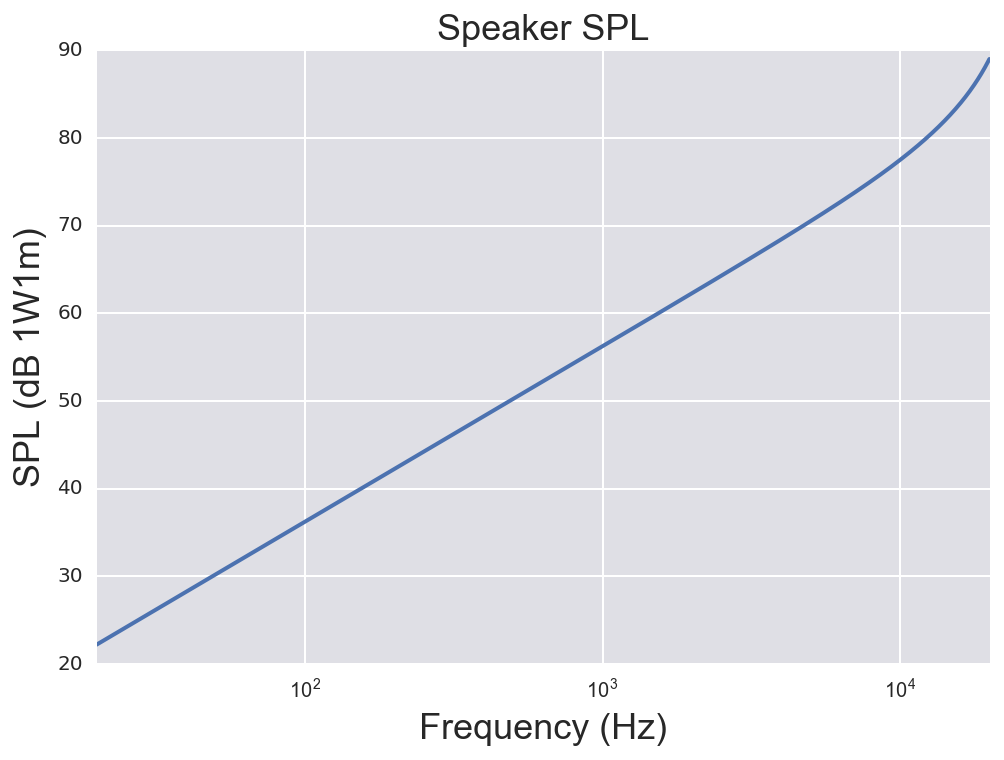

In [101]:
# test speaker setup
fe103en = {
    'name': 'Fostex FE103En',
    'sensitivity': 89., 
    'sd': 0.0050,
    'mms': 0.00255,
    'cms': 0.00165,
    'rms': None,
    're': 7.5,
    'le': 0.0398,
    'bl': 4.99,
    'vas': 5.95,
    'fs': 83.,
    'qts': 0.33,
    'qes': 0.377,
    'qms': 2.747,
    'vd': None,
    'xmax': 0.6
}

alpha15 = {
    'name': 'Eminence Alpha 15',
    'sensitivity': 97., 
    'sd': 856.3,
    'mms': 59.,
    'cms': 0.25,
    're': 5.88,
    'le': 0.84,
    'bl': 7.7,
    'vas': 260.,
    'fs': 41.,
    'qts': 1.26,
    'qes': 1.53,
    'qms': 7.23,
    'rms': None
}

speaker = Speaker(alpha15)
# fill up missing parameters if possible
calc_params(speaker)

print(speaker)

r_ = calculate_impedance(speaker, v_box=60., l_over_a=0.3)

fig = plt.figure()
ax_power = fig.add_subplot(111, title="Speaker SPL")
ax_power.plot(r_['omega'] / 2. / np.pi, r_['power_spl'])
ax_power.set_ylabel('SPL (dB 1W1m)')
ax_power.set_xlabel('Frequency (Hz)')
ax_power.set_xscale('log')
ax_power.set_xlim([20, 20000])

P(A∣B)=P(B∣A)P(A)P(B)P(A∣B)=P(B∣A)P(A)P(B)